# Lorenz system - Paper Replication

## Data Generation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
import pysindy as ps
from sklearn.linear_model import Lasso
import scienceplots
plt.style.use(["science", "notebook", "grid"])

Note that from the ```lorenz``` from ```PySINDy``` has already the parameters we want by default, but I'll stick to my implementation to avoid bugs.


In [2]:
def lorenz(t, x, sigma=10, beta=8/3, rho=28):
    """
    Lorenz system data

    Args:
        x (array): Data
        sigma (float, optional): Parameter. Defaults to 10.
        beta (float, optional): Parameter. Defaults to 8/3.
        rho (float, optional): Parameter. Defaults to 28.

    Returns:
        array: Lorenz system data
    """
    return [sigma * (x[1] - x[0]), x[0] * (rho - x[2]) - x[1], x[0] * x[1] - beta * x[2]]

In [3]:
delta_t = 0.001
time = np.arange(0, 100, delta_t)
x0 = [-8, 8, 27]
x_train = solve_ivp(lorenz, (time[0], time[-1]), x0, t_eval=time, rtol = 1e-12, method = "LSODA", atol = 1e-12).y.T
x_data = x_train[:, 0]
y_data = x_train[:, 1]
z_data = x_train[:, 2]

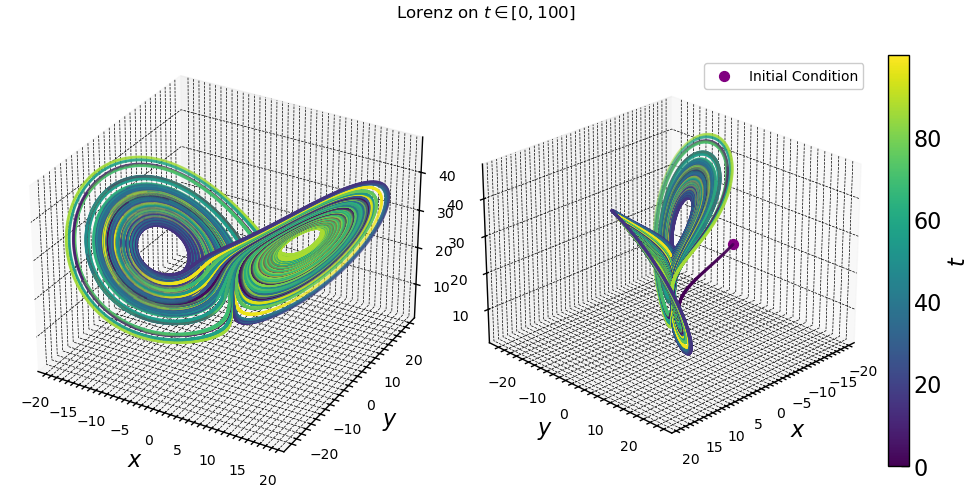

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': '3d'})
scatter1 = axes[0].scatter(x_data, y_data, z_data, c=time, cmap='viridis', marker='.', linewidths=0.0001)
axes[0].set(xlabel="$x$", ylabel="$y$", zlabel="$z$")
axes[0].xaxis.set_tick_params(labelsize=10)
axes[0].yaxis.set_tick_params(labelsize=10)
axes[0].zaxis.set_tick_params(labelsize=10)
scatter2 = axes[1].scatter(x_data, y_data, z_data, c=time, cmap='viridis', marker='.', linewidths=0.0001)
axes[1].scatter(x_data[0], y_data[0], z_data[0], color='purple', s=50, label='Initial Condition')
axes[1].set(xlabel="$x$", ylabel="$y$")
axes[1].xaxis.set_tick_params(labelsize=10)
axes[1].yaxis.set_tick_params(labelsize=10)
axes[1].zaxis.set_tick_params(labelsize=10)
axes[1].legend(prop={'size': 10})
plt.colorbar(scatter2, ax=axes[1], label='$t$', fraction=0.046, pad=0.04)
axes[1].view_init(azim=45, elev=25)
fig.suptitle("Lorenz on $t\in[0,100]$")
plt.tight_layout()
plt.show()

## SINDy

### $\mathbf{X'}$ measured

In [5]:
x_derivative_train = np.array([lorenz(0, x_train[t]) for t in range(time.size)]) # X' (no noise)

#### Clean Data

In [6]:
feat_names = ["x", "y", "z"]
opt = ps.STLSQ(threshold=0.025)
poly_lib = ps.PolynomialLibrary(degree=5)
diff_method = ps.FiniteDifference()
short_time = np.arange(0, 20, delta_t) # define simulation time
model = ps.SINDy(optimizer=opt, feature_library=poly_lib, differentiation_method=diff_method, feature_names=feat_names) # define model
model.fit(x_train, delta_t, x_derivative_train) # determine model

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(degree=5),
      feature_names=['x', 'y', 'z'], optimizer=STLSQ(threshold=0.025))

In [7]:
model.coefficients()

array([[  0.        , -10.        ,  10.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ,   0.        ],
       [  0.        ,  28.        ,  -1.        ,   0.        ,
          0.        ,   0.        ,  -1

In [8]:
model.print(precision = 5) # print trained model

(x)' = -10.00000 x + 10.00000 y
(y)' = 28.00000 x + -1.00000 y + -1.00000 x z
(z)' = -2.66667 z + 1.00000 x y


In [9]:
model.score(x_train, time, x_derivative_train)

1.0

We have identified the coefficients of the model with perfect accuracy. Let's verify it with each coordinate on a shorter time frame with $t\in[0,20]$.

In [10]:
model_sim = model.simulate(x0, short_time)

In [11]:
model_sim_x = model_sim[:, 0]
model_sim_y = model_sim[:, 1]
model_sim_z = model_sim[:, 2]

In [12]:
def plot_xyz_lorenz(sim_x, sim_y, sim_z, time_limit = time, x=x_data, y=y_data, z=z_data, title="Clean Data"):
    """
    Plots dynamics of Lorenz in x,y,z

    Args:
        sim_x (_type_): Simulated data for x
        sim_y (_type_): Simulated data for y
        sim_z (_type_): Simulated data for z
        time_limit_size (int): Number of time steps to plot. Defaults to time.size.
        x: True data for x. Defaults to x_data.
        y: True data for y. Defaults to y_data.
        z: True data for z. Defaults to z_data.
        title: part of text to put in the title of the plot
    """
    fig, axes = plt.subplots(3, 1, figsize=(10, 6))

    axes[0].plot(time[:time_limit.size], x[:time_limit.size], label='True', c = "k")
    axes[0].plot(time[:time_limit.size], sim_x, "r--", label='SINDy')
    axes[0].set_ylabel('$x$', fontsize = 15)
    axes[0].legend(loc = "lower right", prop={'size': 10})
    axes[0].xaxis.set_ticklabels([])
    axes[0].yaxis.set_tick_params(labelsize=10)

    axes[1].plot(time[:time_limit.size], y[:time_limit.size], c = "k")
    axes[1].plot(time[:time_limit.size], sim_y, "r--")
    axes[1].set_ylabel('$y$', fontsize = 15)
    axes[1].xaxis.set_ticklabels([])
    axes[1].yaxis.set_tick_params(labelsize=10)

    axes[2].plot(time[:time_limit.size], z[:time_limit.size], c = "k")
    axes[2].plot(time[:time_limit.size], sim_z, "r--")
    axes[2].set_xlabel('$t$', fontsize = 15)
    axes[2].set_ylabel('$z$', fontsize = 15)
    axes[2].xaxis.set_tick_params(labelsize=10)
    axes[2].yaxis.set_tick_params(labelsize=10)
    plt.suptitle(f"True vs SINDy in $(x,y,z)$ for $t\in[0,{int(time_limit.size*delta_t)}]$, {title}")
    plt.tight_layout()
    plt.show()

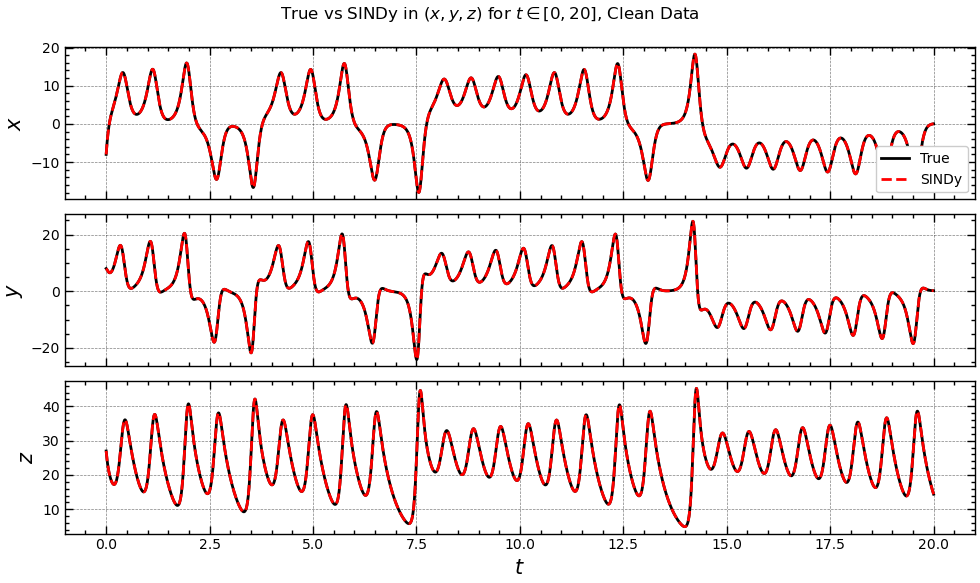

In [13]:
plot_xyz_lorenz(model_sim_x, model_sim_y, model_sim_z, short_time)

Results correctly reproduced.

#### Noisy Data

Here the noise is added to the derivative. It is a zero-mean Gaussian noise with variance $\eta\in\{0.01,10\}$. The simulations are done untile time 20.

In [14]:
noises = [0.01, 10]
models = []
models_sim = []
np.random.seed(1000)
x0 = [-8, 8, 27]
for noise in noises:
    model = ps.SINDy(optimizer=ps.STLSQ(threshold=0.05), feature_library=ps.PolynomialLibrary(degree=5))
    model.fit(x_train, t = delta_t, x_dot=x_derivative_train + np.random.normal(loc=0.0, scale=noise, size=x_train.shape))
    models.append(model)
    models_sim.append(model.simulate(x0, short_time))

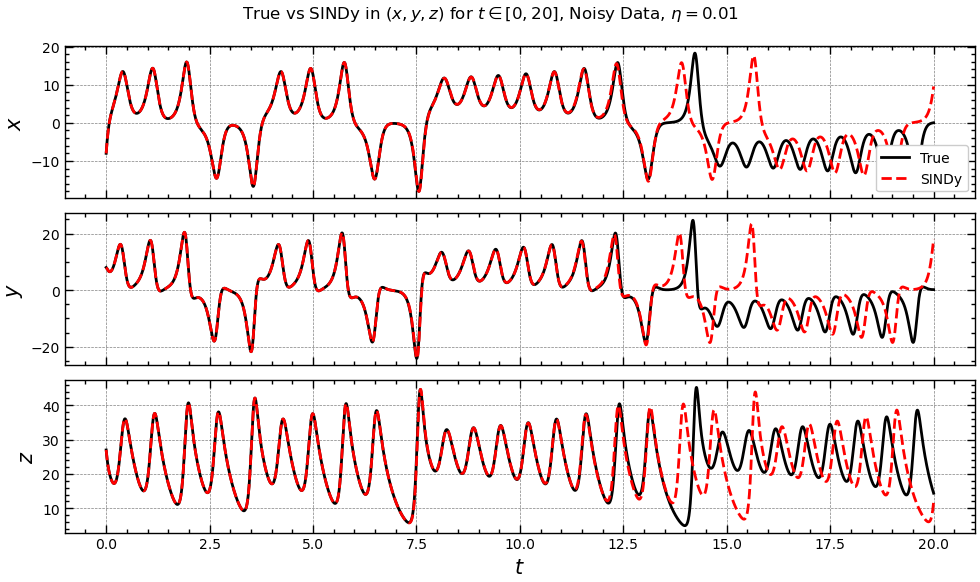

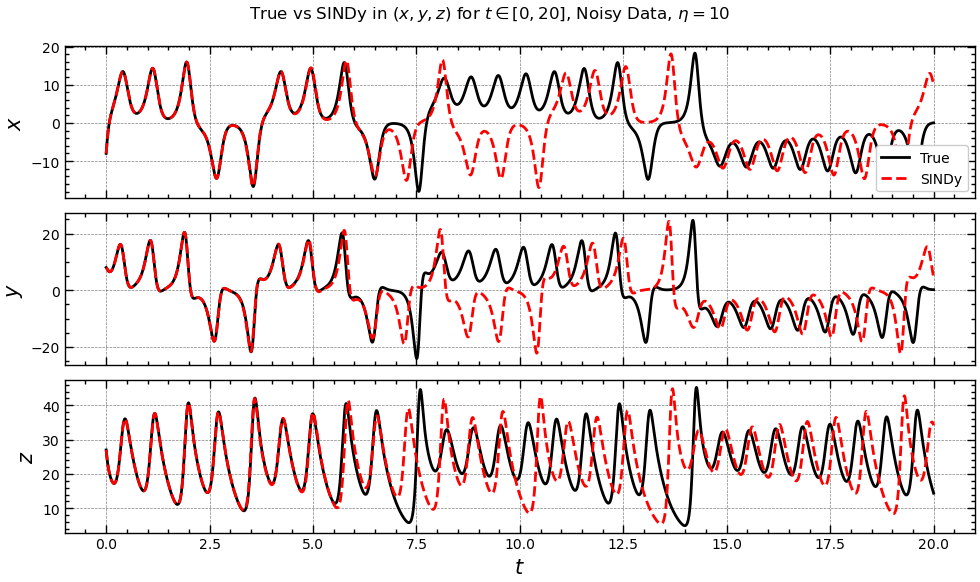

In [15]:
for i, model_sim in enumerate(models_sim):
        plot_xyz_lorenz(model_sim[:,0], model_sim[:,1], model_sim[:,2], short_time, title=f"Noisy Data, $\eta={noises[i]}$")

The results correclty reproduced, but they diverge at different points. Inizialing with the same used used in the paper might help improving this. 